In [6]:
import torch
import koopmanlab as kp
import h5py
from timeit import default_timer
# Setting your computing device
# torch.cuda.set_device(0)
device = torch.device("cuda")
import torch.nn as nn
import timm
from functools import lru_cache
# from koopmanlab.utils import adam
from koopmanlab import utils
import numpy as np

import operator
from functools import reduce
import pandas as pd
import time

import imageio
import matplotlib.pyplot as plt

import torchvision
torchvision.__version__

/home/fabuzaev/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.15.0'

In [7]:
data_path = "./data/"

In [8]:
radar_data = np.load(f'{data_path}/radars_2020-11-01_2022-12-31.npy')
glorys     = np.load(f'{data_path}/glorys_2020-11-01_2022-12-31.npy')
gfs = np.load(f'{data_path}/gfs_2020-11-01_2022-12-31.npy')

In [9]:
print('radar data : ', radar_data.shape)
print('glorys data :', glorys.shape)
print('gfs data :', gfs.shape)

radar data :  (791, 825, 200)
glorys data : (791, 3, 825, 200)
gfs data : (791, 3, 825, 200)


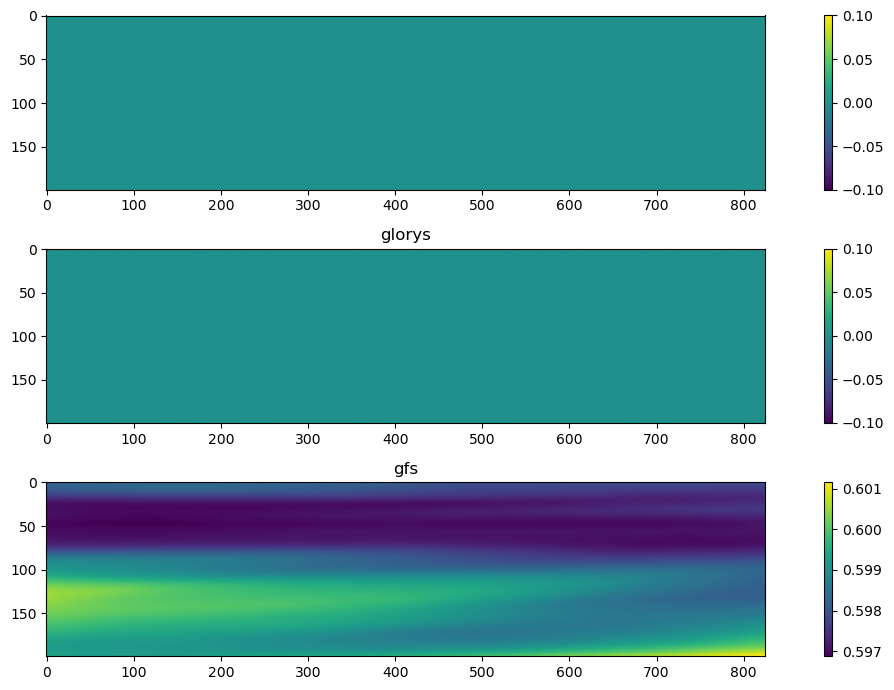

In [10]:
idx = 322
plt.figure(figsize=(12,7)); plt.subplot(3,1,1)
plt.imshow(radar_data[idx].T); plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(glorys[idx,0].T); plt.title('glorys')
plt.colorbar();plt.subplot(3,1,3)
plt.imshow(gfs[idx,0].T); plt.title('gfs');plt.colorbar()
plt.tight_layout()

In [11]:
def load_mask(mask_path):
    '''
    loads binary mask with river from mask_path.
    
    ## Returns:
        - mask_norm: (2d np.array) normed (0-1) mask image
    '''
    mask = imageio.v3.imread(mask_path)
    mask = mask.mean(-1)
    v_min, v_max = mask.min(), mask.max()
    new_min, new_max = 1,0

    mask_norm = (mask - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    return mask_norm

def get_clear_data_idxs(radar_data, zero_th_percent , mask = None):
    '''
    Returns radar idxs where number of zeros less then @zero_th_percent in percent
    
    ## Inputs:
        - radar_data: (np.array) radar data (3d np array)
        - zero_th_percent : (float) threshold in percent. How many zeros are allowed. In interval (0, 100)
        - mask : (np.array) 2D mask where zeros should be counted. In mask is None - counts zeros on whole image
    
    ## Returns:
        - idxs of clear images
    '''

    assert 0 < zero_th_percent <= 100, 'zero_th_percent must be within interval 0 and 100'
    
    radar_post = radar_data * (radar_data >= 0)     # turn negatives to zeros
    zeros = radar_post == 0                         # get zeros positions 

    if mask is None:                                # if we have a mask
        N_pixls = zeros.sum(-1).sum(-1)             # number of all pixels
        zeros_selected = zeros                      # select all pixels 
    else:                                           # if no Mask
        zeros_selected = zeros * mask               # select zeros within mask
        N_pixls = mask.sum(-1).sum(-1)              # number of all pixels in mask

    n_zeros = zeros_selected.sum(-1).sum(-1)        # number of zeros per image
    p_zeros = n_zeros/N_pixls * 100                 # percentage of zeros per image
    nz_mask = p_zeros < zero_th_percent             # find required image positions

    return np.where(nz_mask)                       # return idxs of required images

In [12]:
mask = load_mask(data_path+'mask.png')

In [13]:
idxs = get_clear_data_idxs(radar_data, 80, mask) 

In [14]:
pairs = []
i = 0
while i < (len(idxs[0]) - 1):
    if (idxs[0][i] - idxs[0][i + 1]) == -1:
        pairs.append([idxs[0][i], idxs[0][i+1]])
        i += 2
    else:
        i += 1

In [15]:
train_pairs = np.array(pairs[:int(166 * 0.7)])
valid_pairs = np.array(pairs[int(166 * 0.7):int(166 * 0.9)])
test_pairs = np.array(pairs[int(166 * 0.9):])

In [16]:
train_pairs[:, 0]

array([  6,   8,  10,  12,  20,  22,  27,  30,  32,  34,  36,  42,  44,
        46,  54,  58,  63,  66,  68,  70,  72,  74,  82,  85,  87,  90,
        92,  94,  97,  99, 106, 109, 111, 116, 119, 126, 128, 130, 132,
       134, 138, 140, 142, 145, 147, 150, 152, 154, 156, 158, 162, 164,
       166, 171, 174, 176, 183, 186, 188, 190, 195, 198, 200, 202, 207,
       210, 330, 332, 334, 336, 342, 344, 349, 351, 356, 359, 361, 363,
       366, 368, 370, 372, 378, 383, 385, 387, 390, 392, 395, 397, 399,
       402, 404, 406, 409, 416, 423, 426, 428, 430, 440, 443, 447, 450,
       455, 457, 459, 461, 463, 469, 471, 474, 476, 479, 481, 483])

## Dataloader

In [17]:
batch_size = 50

In [18]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(radar_data[train_pairs[:, 0]]), 
                                                                          torch.Tensor(radar_data[train_pairs[:, 1]])), 
                                                                           batch_size=batch_size, shuffle=True, 
                                                                           pin_memory=True)


valid_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(radar_data[valid_pairs[:, 0]]), 
                                                                          torch.Tensor(radar_data[valid_pairs[:, 1]])), 
                                                                          batch_size=batch_size, shuffle=False, 
                                                                          pin_memory=True)


test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(radar_data[test_pairs[:, 0]]), 
                                                                         torch.Tensor(radar_data[test_pairs[:, 1]])), 
                                                                         batch_size=batch_size, shuffle=False, 
                                                                         pin_memory=True)


In [19]:
for x_train, y_train in train_loader:
    print(x_train.shape)
    break

torch.Size([50, 825, 200])


## Neural Network modules

In [20]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x
    

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.mlp1(x)
        x = self.act(x)
        x = self.mlp2(x)
        return x


class FourierLayer2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, normalization=False):
        
        super(FourierLayer2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.modes1 = modes1
        self.modes2 = modes2
        self.normalization = normalization

        self.act = nn.GELU()

        self.spectral_conv = SpectralConv2d(in_channels=self.in_channels, out_channels=self.out_channels,
                                            modes1=self.modes1, modes2=self.modes2)
        
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, 1)
        self.norm = nn.LayerNorm(self.out_channels)
        self.mlp = MLP(self.out_channels, self.out_channels, self.out_channels)

    def forward(self, x):
        x_spectral = self.spectral_conv(x)
        if self.normalization:
            x_spectral = self.norm(x_spectral)
        x_spectral = self.mlp(x_spectral)
        x_conv = self.conv(x)
        return self.act(x_spectral + x_conv)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, normalization=False):
        super(DoubleConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.mid_channels = (self.in_channels + self.out_channels) // 2

        self.modes1 = modes1
        self.modes2 = modes2
        self.normalization = normalization

        self.conv_1 = FourierLayer2d(in_channels=self.in_channels, out_channels=self.mid_channels, 
                                     modes1=self.modes1, modes2=self.modes2, normalization=self.normalization)
        
        self.conv_2 = FourierLayer2d(in_channels=self.mid_channels, out_channels=self.out_channels, 
                                     modes1=self.modes1, modes2=self.modes2, normalization=self.normalization)
        
        
        self.act = nn.GELU()

    
    def forward(self, x):

        x_down_1 = self.conv_1(x)
        x_down_1 = self.act(x_down_1)
        x_down_2 = self.conv_2(x_down_1)
        x_down_2 = self.act(x_down_2)
        return x_down_2

In [21]:
class DownsampleLayer(nn.Module):
    def __init__(self, width=256):
        super(DownsampleLayer, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Upsample(size=(width, width), mode='bilinear', align_corners=False),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class UpsampleLayer(nn.Module):
    def __init__(self):
        super(UpsampleLayer, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Upsample(size=(825, 200), mode='bilinear', align_corners=False),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [22]:
class encoder_mlp(nn.Module):
    def __init__(self, t_len, op_size):
        super(encoder_mlp, self).__init__()
        self.layer = nn.Linear(t_len, op_size)
    def forward(self, x):
        x = self.layer(x)
        return x

class decoder_mlp(nn.Module):
    def __init__(self, t_len, op_size):
        super(decoder_mlp, self).__init__()
        self.layer = nn.Linear(op_size, t_len)
    def forward(self, x):
        x = self.layer(x)
        return x

In [23]:
class DownsampleEncoder(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(DownsampleEncoder, self).__init__()
        
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        self.linear_1 = nn.Linear(self.input_shape, self.input_shape//2)
        
        self.linear_2 = nn.Linear(self.input_shape//2, self.output_shape)
        
        self.act = nn.GELU()
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        
        return x

class UpsampleDecoder(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(UpsampleDecoder, self).__init__()
        
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        self.linear_1 = nn.Linear(self.input_shape, self.input_shape*2)
        
        self.linear_2 = nn.Linear(self.input_shape*2, self.output_shape)
        
        self.act = nn.GELU()
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = self.act(x)
        x = self.linear_2(x)
        
        return x

In [24]:
class UFNO2d(nn.Module):
    def __init__(self, width=64, modes1=64, modes2=64, normalization=False):
        super(UFNO2d, self).__init__()

        self.width = width
        self.modes1 = modes1
        self.modes2 = modes2
        
        self.encoder = encoder_mlp(1, self.width)
        self.decoder = decoder_mlp(1, self.width)
        
        self.act = nn.GELU()
        
        self.down_layer_1 = DoubleConv(self.width, self.width//2, self.modes1, self.modes2)
        self.down_layer_2 = DoubleConv(self.width//2, self.width//4, self.modes1, self.modes2)
        self.down_layer_3 = DoubleConv(self.width//4, self.width//8, self.modes1, self.modes2)
        
        self.up_layer_3 = DoubleConv(self.width//8, self.width//4, self.modes1, self.modes2)
        self.up_layer_2 = DoubleConv(self.width//4, self.width//2, self.modes1, self.modes2)
        self.up_layer_1 = DoubleConv(self.width//2, self.width, self.modes1, self.modes2)

        self.downsample = DownsampleEncoder(825, 200)
        self.upsample = UpsampleDecoder(200, 825)
        
        
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        
        # x = x.unsqueeze(1)
        x = self.downsample(x.permute(0, 2, 1))
        x = self.act(x)
        
        x = x.unsqueeze(1)
        x = x.permute(0, 2, 3, 1)
        
        x = self.encoder(x)
        x = self.act(x)
        x = x.permute(0, 3, 1, 2)
        
        x_down_1 = self.down_layer_1(x)
        x_down_2 = self.down_layer_2(x_down_1)
        x_down_3 = self.down_layer_3(x_down_2)
        
        x_up_3 = self.up_layer_3(x_down_3)
        x_up_2 = self.up_layer_2(x_down_2 + x_up_3)
        x_up_1 = self.up_layer_1(x_down_1 + x_up_2)
        
        x = x_up_1 + x
        
        x = x.permute(0, 2, 3, 1)
        x = self.decoder(x)
        
        x = self.act(x)
        
        x = x.permute(0, 3, 1, 2)
        x = x.squeeze()
        
        x = self.upsample(x)
        x = x.permute(0, 2, 1)
        
        return x


In [31]:
model = UFNO2d(normalization=True, width=32, modes1=10, modes2=10).to(device)
optimizer = utils.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, min_lr=1e-5)

In [32]:
with torch.no_grad():
    print(model(x_train.to(device)).shape)

torch.Size([50, 825, 200])


In [33]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

count_params(model)

2054082

In [34]:
## Train

In [35]:
def train(device, model, optimizer, scheduler, trainloader, epochs=20, evalloader=False, name_experiment='model_test'):
    train_loss_list = []
    valid_loss_list = []
    grad_list = []
    
    for ep in range(epochs):
        percent_epoch  = ep/epochs
        model.train()
        t_1 = default_timer()
        train_pred_full = 0
        total_grad = 0
        for x_train, y_train in trainloader:
            l_recons = 0
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            bs = x_train.shape[0]
            pred = model(x_train)
            loss = model.loss(pred.reshape(bs, -1), y_train.reshape(bs, -1))

            train_pred_full += loss.item()

            optimizer.zero_grad()
            loss.backward()
            grad_by_batch  =  0
            for tag, value in model.named_parameters():
                if value.grad is not None:
                    grad =  value.grad.norm()
                    total_grad += grad 
                    grad_by_batch += grad

            optimizer.step()
            
        grad_list.append(total_grad.cpu().item())

        train_pred_full = train_pred_full / len(trainloader)

        train_loss_list.append(train_pred_full)

        t2 = default_timer()
        valid_pred_full = 0

        if evalloader:
            model.eval()
            with torch.no_grad():
                for x_valid, y_valid in evalloader:
                    loss = 0
                    x_valid = x_valid.to(device)
                    y_valid = y_valid.to(device)
                    bs = x_valid.shape[0]
                    
                    pred = model(x_valid)

                    l_pred = model.loss(pred.reshape(bs, -1), y_valid.reshape(bs, -1))

                    valid_pred_full += l_pred.item()

            valid_pred_full = valid_pred_full / len(evalloader)

            valid_loss_list.append(valid_pred_full)

        scheduler.step(loss)
        # scheduler.step()

        if evalloader:
            if ep == 0:
                print("Epoch", "Time", "[Train Pred MSE]", "[Eval Pred MSE], [total grad], [grad_by_batch]")
            if ep % 50 == 0:
                print(ep, t2 - t_1, train_pred_full, valid_pred_full, total_grad, grad_by_batch)


        if ep % 99 == 0:
            torch.save(model.state_dict(), f"best_models_weights/{name_experiment}_{ep}.pth")
            
    return train_loss_list, valid_loss_list, grad_list

In [ ]:
train_loss_list, valid_loss_list, grad_list = train(device, model, optimizer, 
                                        scheduler, train_loader, epochs=1400, 
                                         evalloader=valid_loader)

Epoch Time [Train Pred MSE] [Eval Pred MSE], [total grad], [grad_by_batch]
0 0.8199495570152067 0.46356578667958576 0.34303826093673706 tensor(0.9864, device='cuda:0') tensor(0.5902, device='cuda:0')
50 0.3871984409634024 0.05692451447248459 0.06743057817220688 tensor(0.3738, device='cuda:0') tensor(0.1276, device='cuda:0')
100 0.38919035997241735 0.057096059123675026 0.06554792076349258 tensor(0.3698, device='cuda:0') tensor(0.1149, device='cuda:0')
150 0.389641190005932 0.052632966389258705 0.0638795718550682 tensor(0.3826, device='cuda:0') tensor(0.1885, device='cuda:0')
200 0.3887031830381602 0.056767068803310394 0.062467288225889206 tensor(0.3526, device='cuda:0') tensor(0.1297, device='cuda:0')
250 0.38742527400609106 0.05443928142388662 0.06098373606801033 tensor(0.3088, device='cuda:0') tensor(0.1833, device='cuda:0')
300 0.392489955003839 0.054177078107992806 0.05959399789571762 tensor(0.4999, device='cuda:0') tensor(0.1144, device='cuda:0')
350 0.3884490610216744 0.0535859689

In [ ]:
for x_test, y_test in test_loader:
    model.eval()
    x_test = x_test.to(device)
    with torch.no_grad():
        prediction = model(x_test)
        
    break

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.imshow(prediction[0].cpu().numpy().T)
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(y_test[0].cpu().numpy().T)
plt.colorbar()